In [1]:
import numpy as np 
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sn

# Загрузка и предобработка данных

In [2]:
def to_categorical(label_array, count_number=10):
    """Пердставить лейбал в виде массива со значением"""
    label_array = np.array(label_array) 
    n = label_array.shape[0]
    categorical = np.zeros((n, count_number))
    categorical[np.arange(n), label_array] = 1
    return categorical


In [3]:
def load_data():
    """Загрузка датасета"""
    (train_X, train_Y), (test_X, test_Y) = mnist.load_data()

    print(train_X.shape)
    # преобразование в 1 канал 
    train_X = train_X.reshape((train_X.shape[0], 28, 28))/255.
    test_X = test_X.reshape((test_X.shape[0], 28, 28))/255.
    
    # перевод в one hot encoder 
    train_Y = to_categorical(train_Y)
    test_Y = to_categorical(test_Y)

    return (train_X.round(), train_Y), (test_X.round(), test_Y)

In [4]:
(train_X, train_Y), (test_X, test_Y) = load_data()

(60000, 28, 28)


In [5]:
train_X[1].max()

1.0

In [6]:
train_Y[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

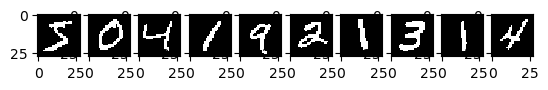

In [7]:
f  = plt.figure()
for i, image  in enumerate(train_X[:10]):
    f.add_subplot(1,10, i+1)
    plt.imshow(image, cmap="gray")
plt.show()

# Персептрон 

In [67]:
class Perceptron:
    """Класс для перцептрона"""
    def __init__ (self, input_shape, output_shape ,epochs =1):
        # Xavier 
        stdv = 1/np.sqrt(input_shape)
        self.W = np.random.uniform(-stdv, stdv, size=(input_shape, output_shape))
        self.b = np.random.uniform(-stdv, stdv, size=output_shape)
        self.epochs = epochs
        self.activate=0
        self.get_csv(self.W, "start_W")
    

    def get_csv(self, array, name):
        np.savetxt(f"weights/{name}.csv", array, delimiter=",")

    #функции активации 
    def ReLU(self, x):
        return np.maximum(0,x)

    def dReLU(self,x):
        return 1 * (x > 0) 

    def softmax(self, z):
        z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
        return np.exp(z) / np.sum(np.exp(z)).reshape(z.shape[0],1)

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    # формирование весов  
    def forward(self, input, activate ):
        
        self.output = np.dot(input, self.W)
        self.output += self.b 
        self.output = activate(self,self.output)
        return self.output   

    # Обучение 
    def train(self, X, Y, activate= ReLU, count_data = 1000,lr =0.001, save_itr = False ):
        self.activate = activate

        for epoch in range(self.epochs):
            for i in range(len(X[:count_data])):
                x = X[i].flatten()
                y_pred = self.forward(x, activate)
                error = Y[i]-y_pred
                x = np.vstack(x)
                D =lr * x*error
                self.W = self.W+D
                if save_itr:
                    self.get_csv(self.W , f"epoch_{epoch}_{i}")
            self.get_csv(self.W , f"epoch_{epoch}")

    # пердсказание
    def pred(self, image):
        x = image.flatten()   
        y_pred = self.forward(x, self.activate)
        return np.argmax(y_pred)      
    

In [61]:
# создание и обучение
perceptron = Perceptron(28*28,10)
perceptron.train(train_X,train_Y, perceptron.dReLU, count_data = 5000)

# Статистика обучения

In [92]:
def stat(perceptron_: Perceptron):
    def confusion_matrix(y_pred, y_true):

        classes = np.unique(y_true)
        classes.sort()
        conf_m = np.zeros(shape=(len(classes), len(classes)))
        for i in classes:
            for j in classes:
                conf_m[i, j] = np.logical_and((y_pred==i), (y_true==j)).sum()
        return conf_m, classes
    
    def accuracy(y_pred, y_true):
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        return (y_pred==y_true).sum()/y_true.size
    
    y_true = []
    y_pred = []
    for x, y in zip(test_X,test_Y):
        y_true.append(np.argmax(y))
        y_pred.append(perceptron_.pred(x)) 
        
    confusion_matrix = confusion_matrix(y_pred,y_true)
    print("Accuracy:",accuracy(y_pred, y_true)*100)
    df_cm = pd.DataFrame(confusion_matrix[0], range(10), range(10))

    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 8},fmt='g',cmap="Greens") # font size
    plt.show()

In [93]:
def view_weigts(perceptron_:Perceptron):
    f  = plt.figure(figsize=(20,20))
    for size, i in enumerate(perceptron_.W.T):
        f.add_subplot(5,5, size+1)
        plt.grid(False)
        plt.imshow(i.reshape((28,28)), cmap='gray')
    
    plt.show()

# Тесты

In [94]:
test_1 = {"activate":[Perceptron.ReLU, Perceptron.sigmoid, Perceptron.dReLU], "count_data": [5000,5000,5000], "epochs": [1,1,1], "lr":[0.001,0.001,0.001]}
test_2 = {"activate":[Perceptron.ReLU, Perceptron.sigmoid, Perceptron.dReLU], "count_data": [5000,5000,5000], "epochs": [1,1,1], "lr":[0.01,0.01,0.01]}
test_3 = {"activate":[Perceptron.ReLU, Perceptron.sigmoid, Perceptron.dReLU], "count_data": [5000,5000,5000], "epochs": [1,1,1], "lr":[0.1,0.1,0.1]}



In [95]:
def get_test(test):

    for i in range(len(test['activate'])):
        print("Функция активации:", test['activate'][i])
        print("Кол-во обучающих данных:", test['count_data'][i])
        print("Кол-во эпох:", test['epochs'][i])
        print("Скорость обучения:", test['lr'][i])
        perceptron_1 = Perceptron(28*28,10,test['epochs'][i])
        perceptron_1.train(train_X,train_Y, test["activate"][i],test["count_data"][i], test['lr'][i])
        stat(perceptron_1)
        view_weigts(perceptron_1)

    

Функция активации: <function Perceptron.ReLU at 0x7fdd749ea9d0>
Кол-во обучающих данных: 5000
Кол-во эпох: 1
Скорость обучения: 0.001
Accuracy: 84.95


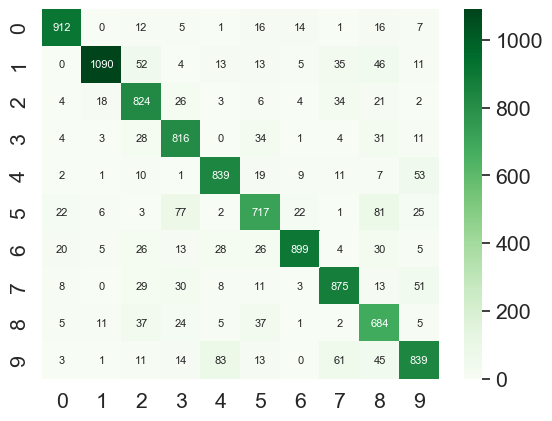

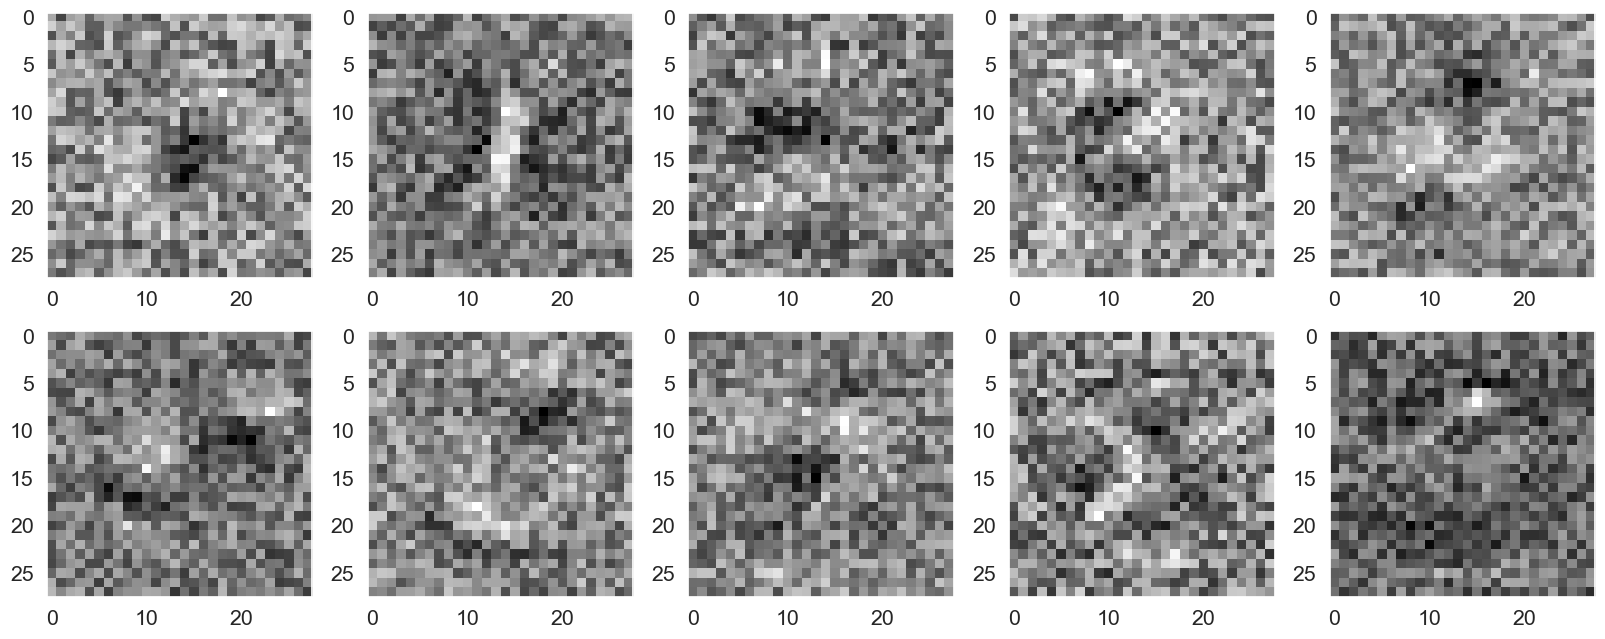

Функция активации: <function Perceptron.sigmoid at 0x7fdd749eae50>
Кол-во обучающих данных: 5000
Кол-во эпох: 1
Скорость обучения: 0.001
Accuracy: 82.52000000000001


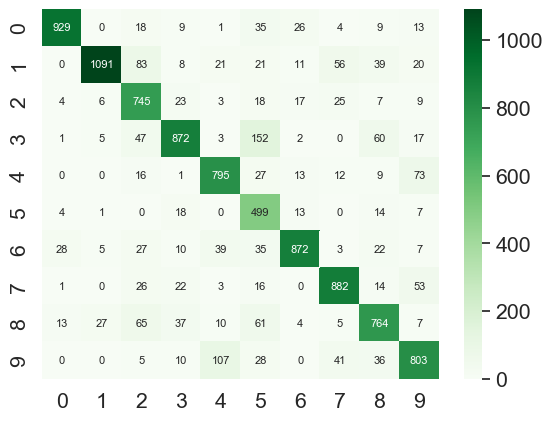

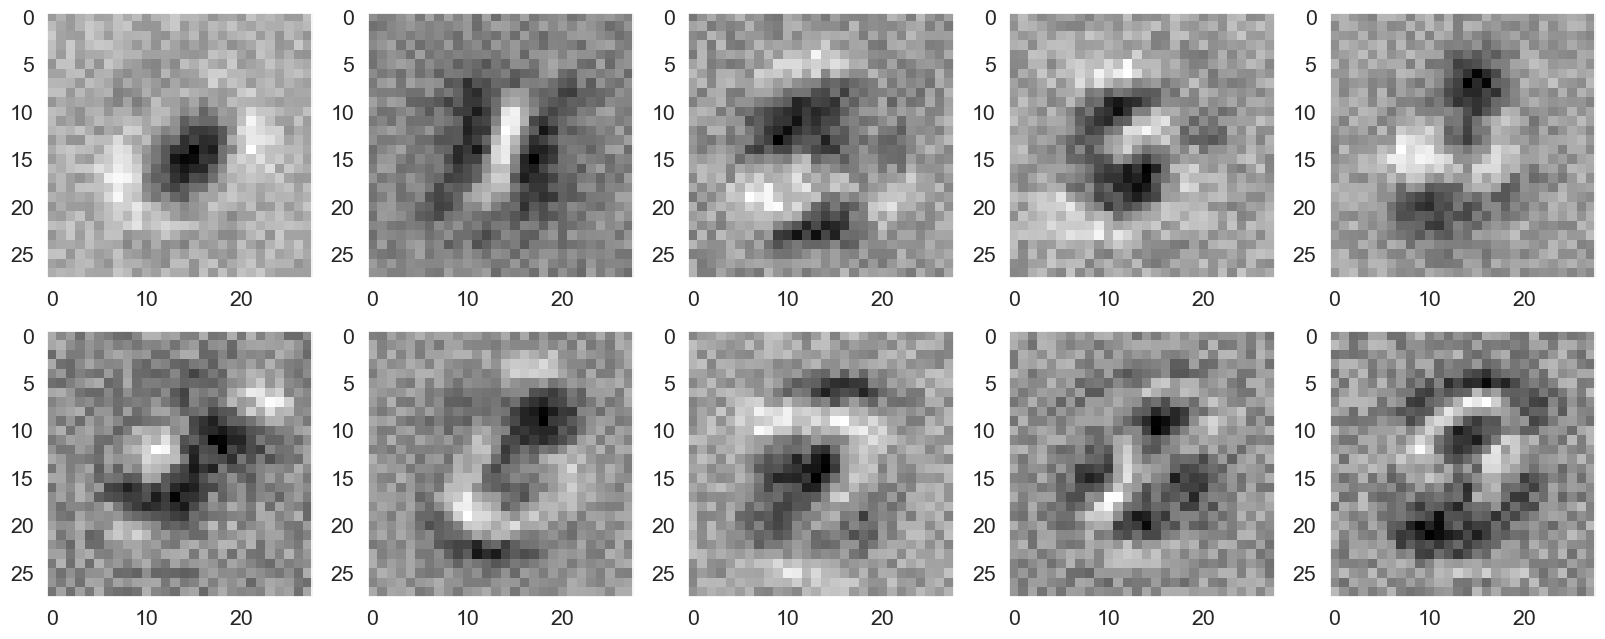

Функция активации: <function Perceptron.dReLU at 0x7fdd749eaca0>
Кол-во обучающих данных: 5000
Кол-во эпох: 1
Скорость обучения: 0.001
Accuracy: 73.22


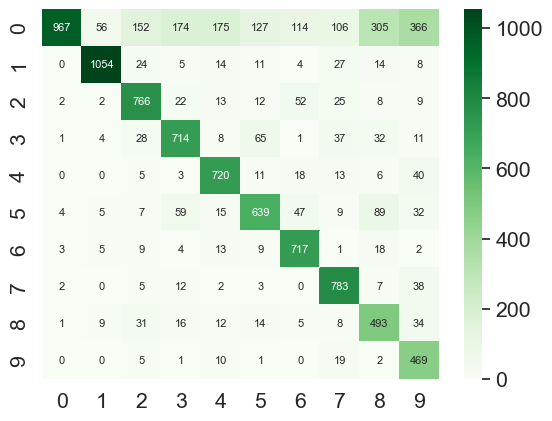

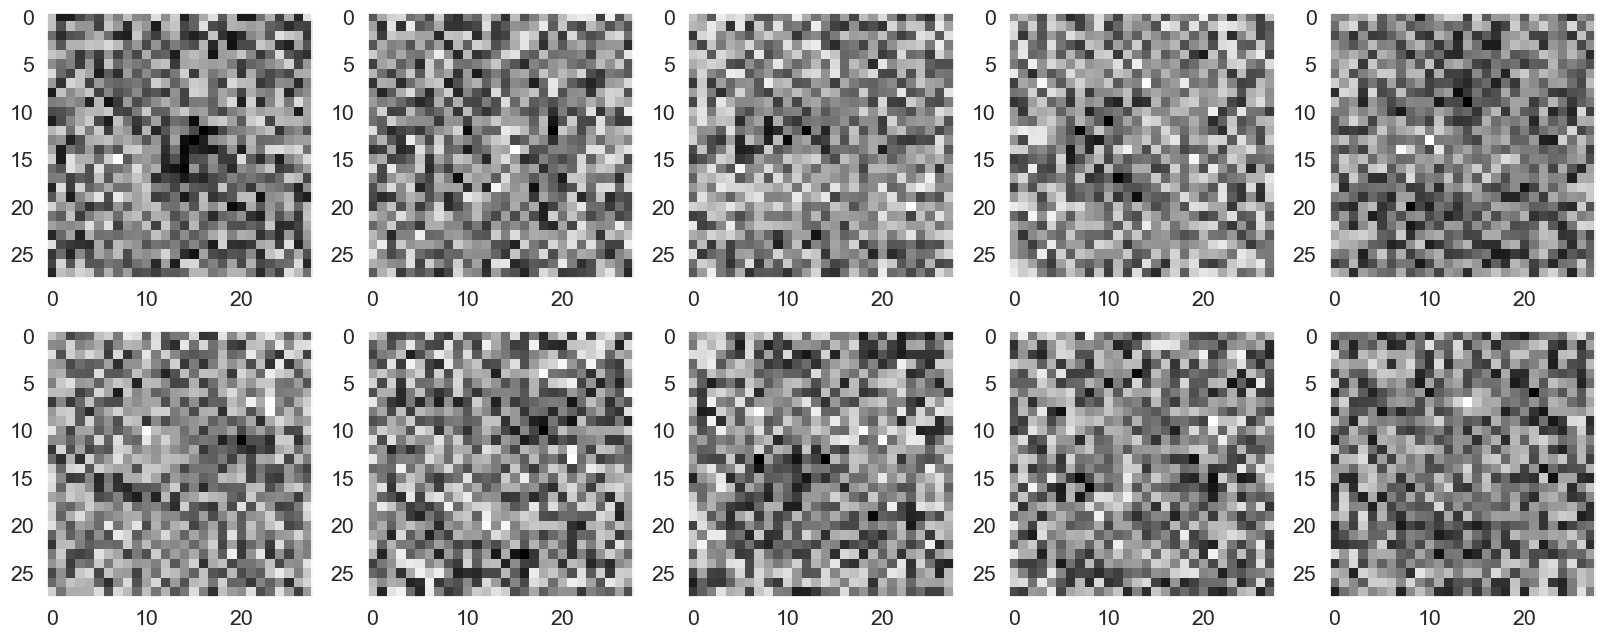

In [96]:
get_test(test_1)

Функция активации: <function Perceptron.ReLU at 0x7fdd749ea9d0>
Кол-во обучающих данных: 5000
Кол-во эпох: 1
Скорость обучения: 0.01
Accuracy: 83.21


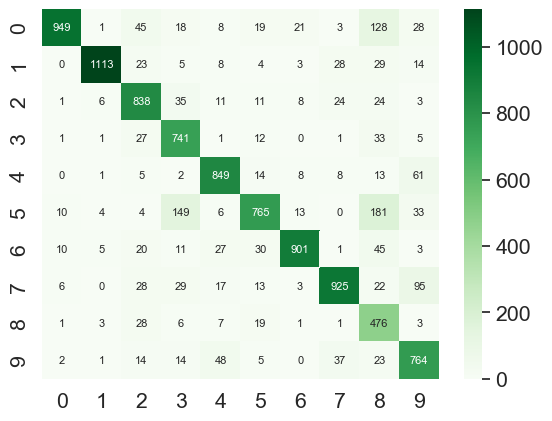

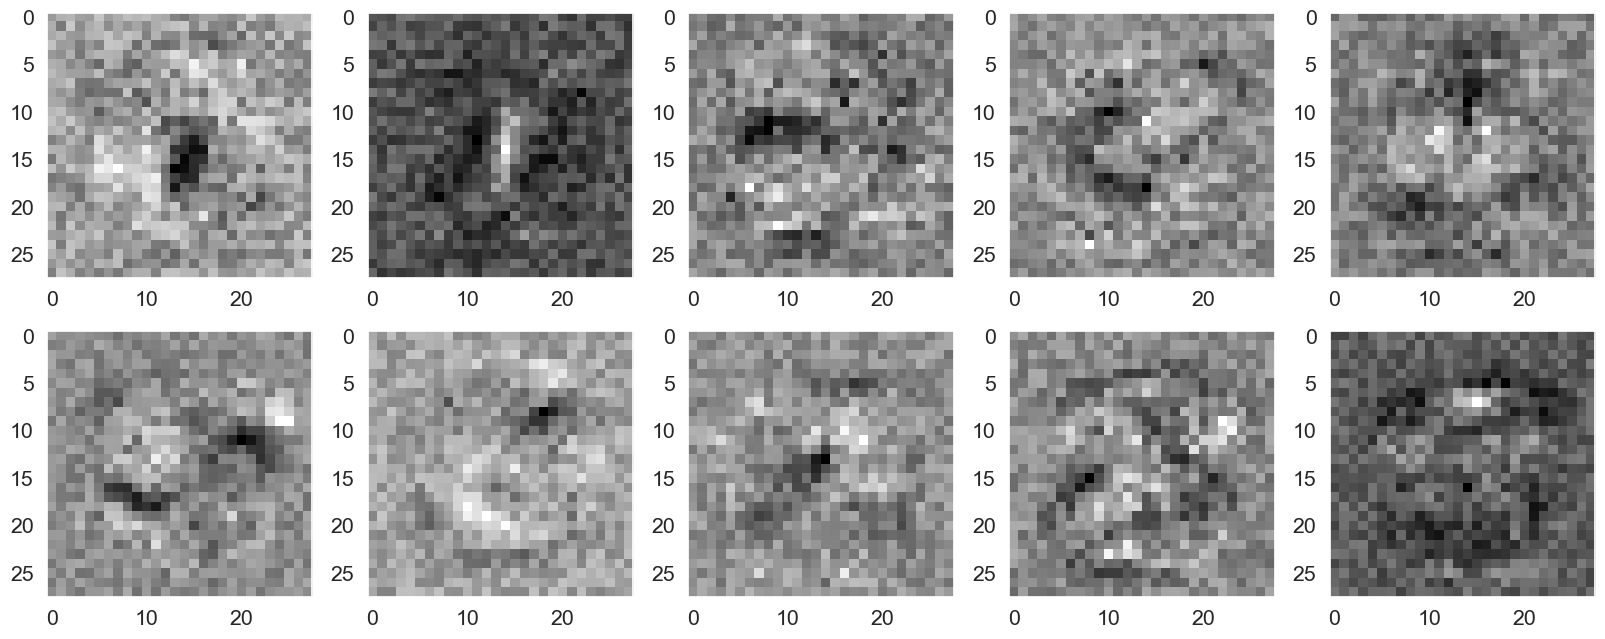

Функция активации: <function Perceptron.sigmoid at 0x7fdd749eae50>
Кол-во обучающих данных: 5000
Кол-во эпох: 1
Скорость обучения: 0.01
Accuracy: 87.15


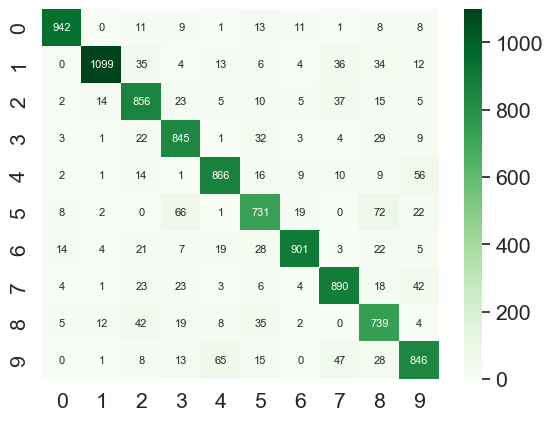

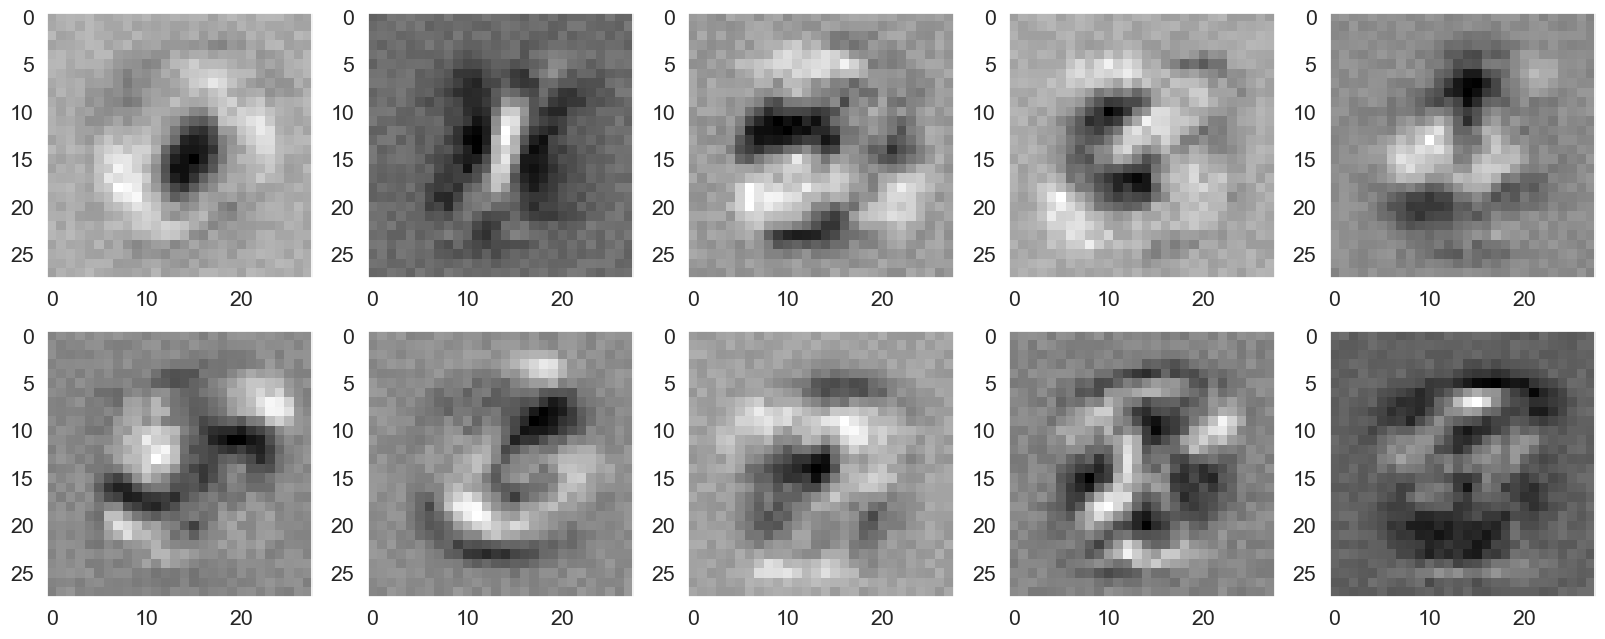

Функция активации: <function Perceptron.dReLU at 0x7fdd749eaca0>
Кол-во обучающих данных: 5000
Кол-во эпох: 1
Скорость обучения: 0.01
Accuracy: 73.67


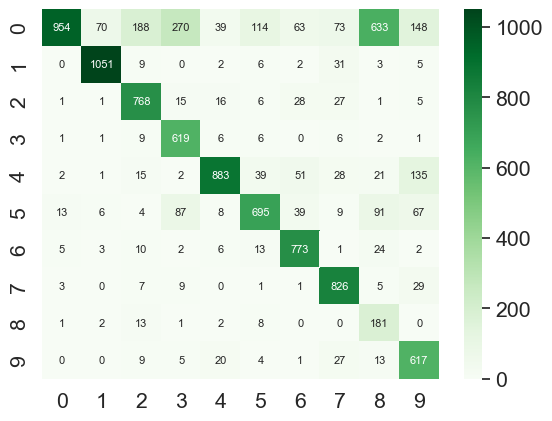

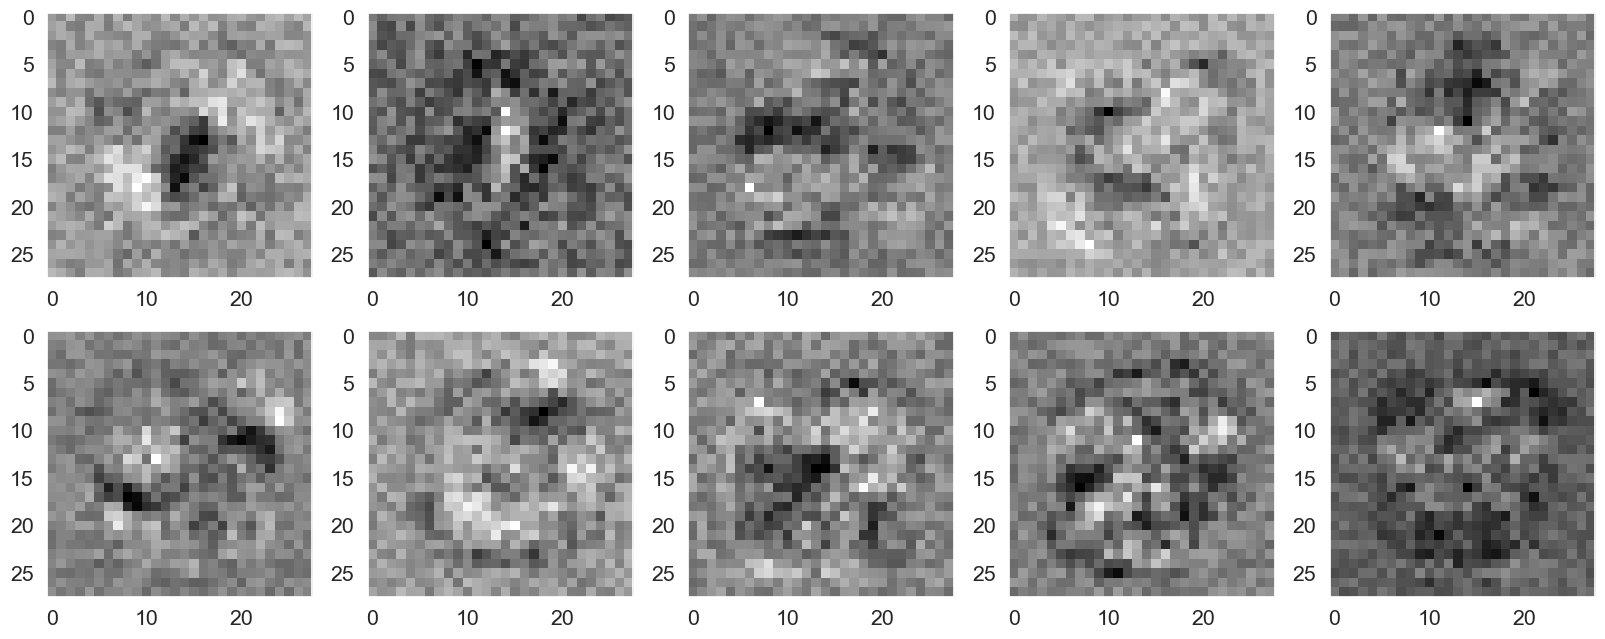

In [97]:
get_test(test_2)

Функция активации: <function Perceptron.ReLU at 0x7fdd749ea9d0>
Кол-во обучающих данных: 5000
Кол-во эпох: 1
Скорость обучения: 0.1
Accuracy: 17.49


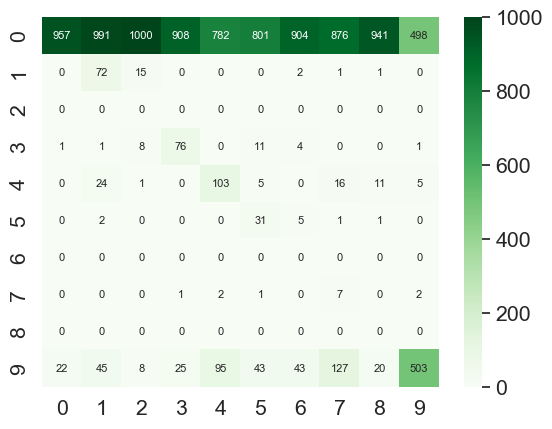

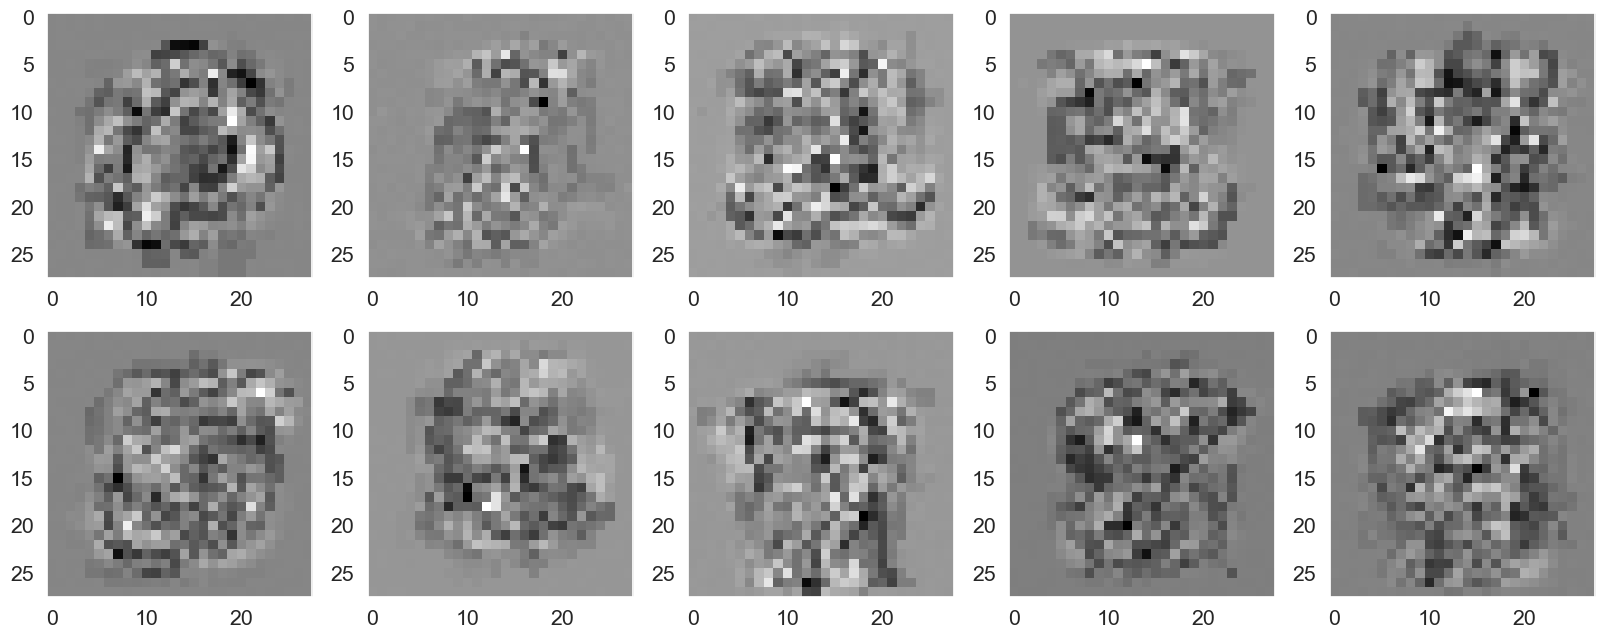

Функция активации: <function Perceptron.sigmoid at 0x7fdd749eae50>
Кол-во обучающих данных: 5000
Кол-во эпох: 1
Скорость обучения: 0.1
Accuracy: 84.91


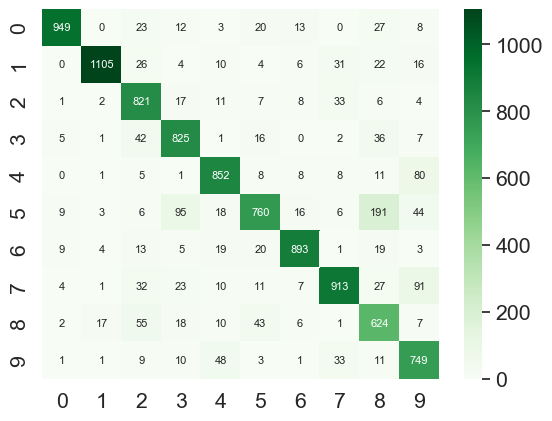

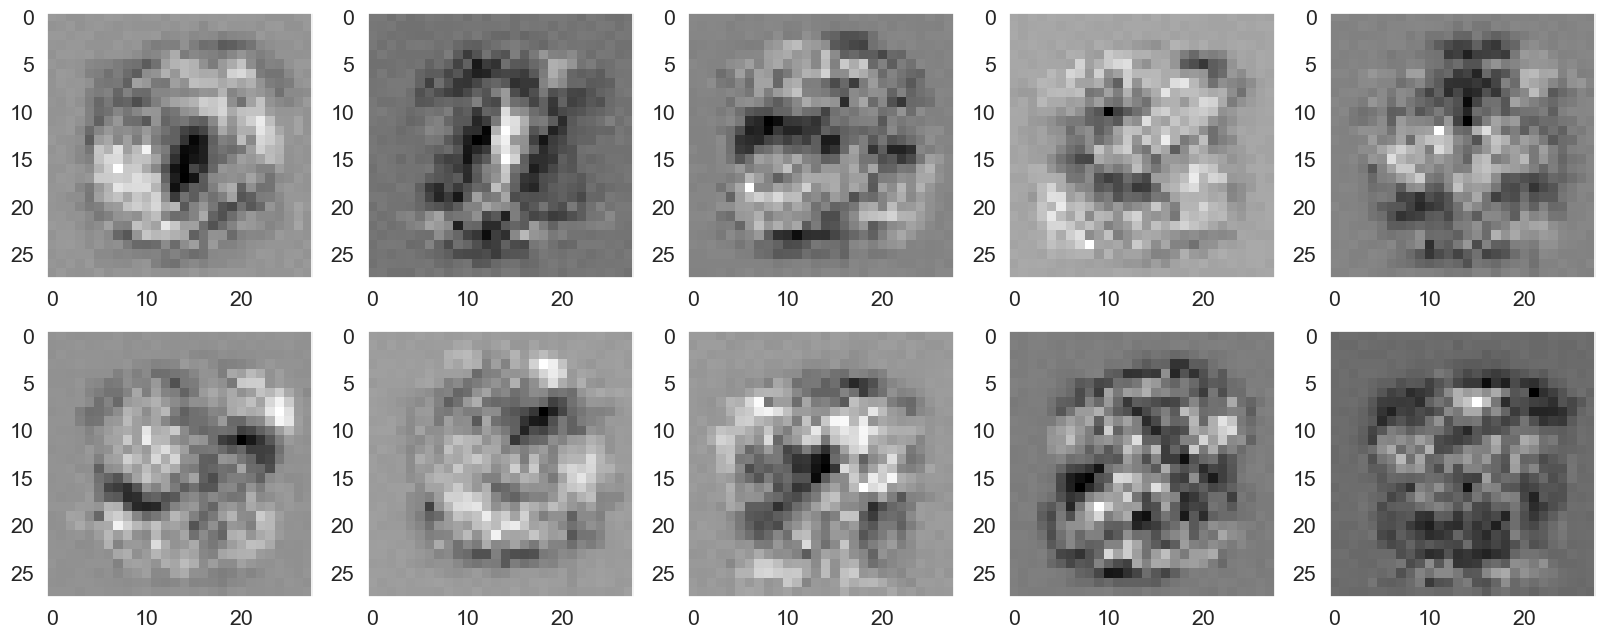

Функция активации: <function Perceptron.dReLU at 0x7fdd749eaca0>
Кол-во обучающих данных: 5000
Кол-во эпох: 1
Скорость обучения: 0.1
Accuracy: 67.47


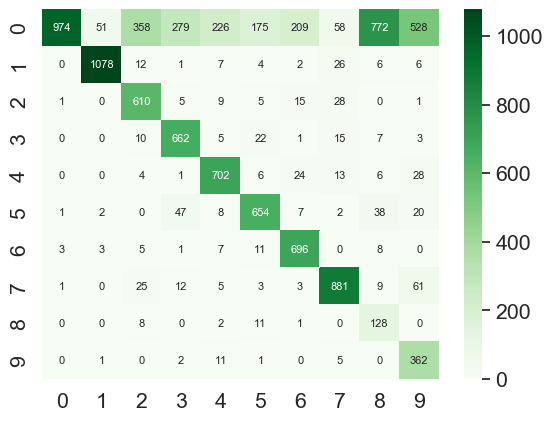

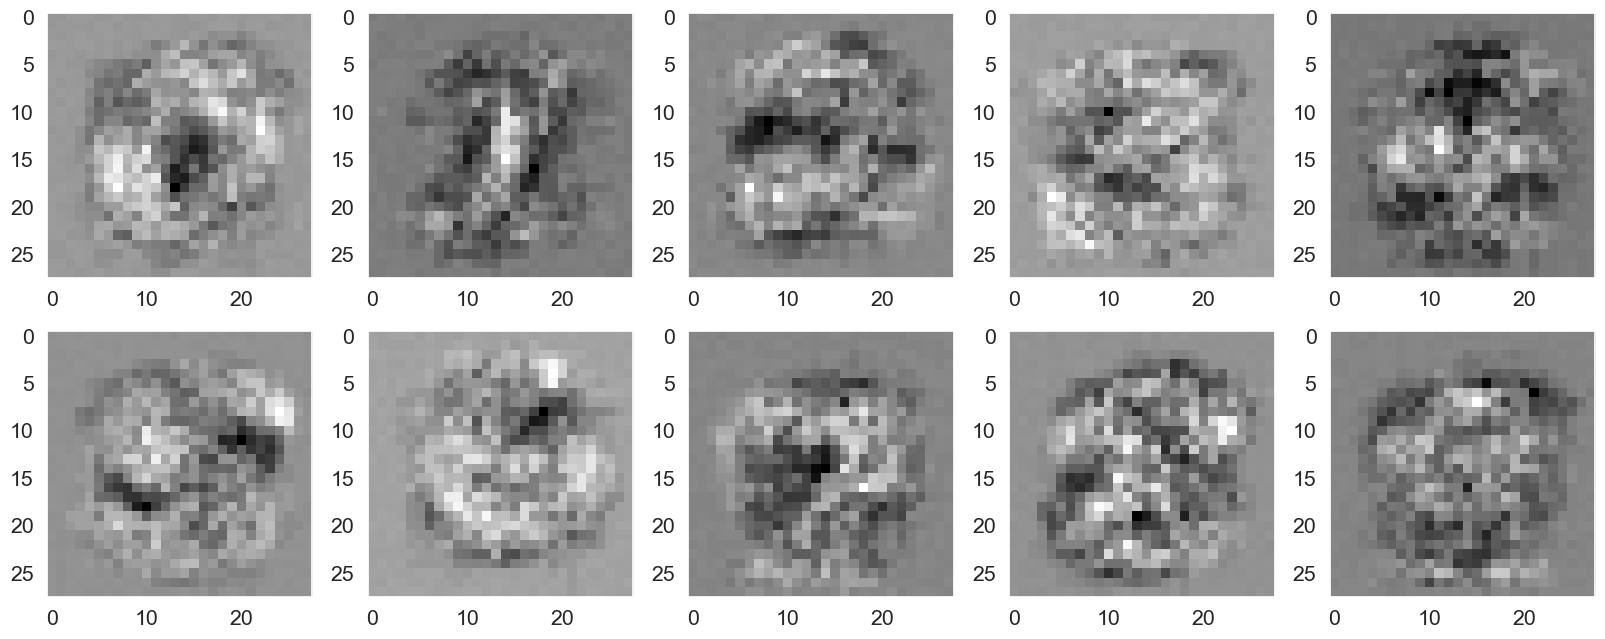

In [98]:
get_test(test_3)